<a href="https://colab.research.google.com/github/phonghnguyen/Colab_NEXAFS/blob/main/F4TCNQ_Quantum_ESPRESSO_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install `ase` for preparing input files, reading output files and visualization

In [2]:
%%capture
!apt install ase
import ase

Some setup for plots later:

In [3]:
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_dirs = ['/content/drive/MyDrive/Fonts/']

font_files = font_manager.findSystemFonts(fontpaths = font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# font_names = [f.name for f in font_manager.fontManager.ttflist]
# print(font_names)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [9]:
qe_relax_input_file = 'F4TCNQ.relax.in'
qe_relax_output_file = 'F4TCNQ.relax.out'

In [10]:
qe_scf_input_file = 'F4TCNQ.scf.in'
qe_scf_output_file = 'F4TCNQ.scf.out'

In [11]:
qe_xspectra_input_file = 'F4TCNQ.xspectra.in'
qe_xspectra_output_file = 'F4TCNQ.xspectra.out'

# Install the Quantum ESPRESSO Binary

In [4]:
%%capture
# Clone the QE git
!git clone https://github.com/QEF/q-e.git
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
# enter the q-e folder
%cd q-e
# run the configure file
!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp

Run the cells to make `pw.x`, `xspectra.x`, and `ld1.x` executables

In [5]:
%%capture
!make pw

In [6]:
%%capture
!make xspectra

In [7]:
%%capture
!make ld1

# Navigate to working directory

In [8]:
%cd /content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/

/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ


# 1. Structural relaxation

Write the input file for structural relaxation calculations (note that the initial atomic positions are from Avagadro):

In [ ]:
qe_input = """
&CONTROL
    calculation='relax',
    prefix='F4TCNQ',
    outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/',
    pseudo_dir = '/content/drive/MyDrive/Quantum_ESPRESSO/SSSP_efficiency/',
    etot_conv_thr = 1e-5
    forc_conv_thr = 1e-4
/
&SYSTEM
    ibrav = 1,
    celldm(1) = 40,
    nat = 20,
    ntyp = 3,
    ecutwfc = 30
/
&ELECTRONS
    conv_thr =  1.0d-8
/
&IONS
/

ATOMIC_SPECIES
F 18.988 f_pbe_v1.4.uspp.F.UPF
N 14.007 N.pbe-n-radius_5.UPF
C 12.011 C.pbe-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS angstrom
F    11.8375459559   13.0485482597   10.5835400000
F     9.2210473915   12.9905253320   10.5835400000
F     9.3296717811    8.1189701881   10.5835400000
F    11.9460691435    8.1762773100   10.5835400000
N     6.2918029468   12.6499123272   10.5835400000
N     6.3883592538    8.3280319218   10.5835400000
N    14.8751234050    8.5171027406   10.5835400000
N    14.7787545396   12.8388905962   10.5835400000
C     6.9603210858   11.7018043587   10.5835400000
C     7.0138672126    9.3050512115   10.5835400000
C    14.2066118200    9.4652156081   10.5835400000
C    14.1531493475   11.8619337965   10.5835400000
C     7.7632400080   10.5207665904   10.5835400000
C    13.4036924793   10.6462640547   10.5835400000
C    12.0421176605   10.6158602775   10.5835400000
C    11.2833322211    9.3497195044   10.5835400000
C     9.9399047795    9.3206477086   10.5835400000
C     9.1247812328   10.5512083461   10.5835400000
C    11.2273820168   11.8468816306   10.5835400000
C     9.8839442542   11.8171314848   10.5835400000

K_POINTS automatic
1 1 1 0 0 0
"""

# We write the input script
with open(qe_relax_input_file, "w") as f:
    f.write(qe_input)

Let's quickly check the input file to make sure our cell size is large enough to isolate individual molecules and that the molecule is centered in the cell.

In [ ]:
from ase import Atoms
from ase.io import read
import numpy as np

# Function to parse celldm(1) from QE input file
def get_celldm(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if 'celldm(1)' in line:
                return float(line.split('=')[1].split(',')[0])

# Read the atomic structure from the QE input file
atoms = read(qe_relax_input_file)

# Get the value of celldm(1)
celldm = get_celldm(qe_relax_input_file)

# Convert celldm(1) from Bohr radius (atomic units) to Angstrom
celldm_angstrom = celldm * 0.529177

# Print the dimensions of the box
print(f"The dimensions of the box are {celldm_angstrom} x {celldm_angstrom} x {celldm_angstrom} Angstrom.")

# Calculate the centroid of the molecule
centroid = atoms.get_center_of_mass()

# The center of the unit cell
center = [celldm_angstrom/2, celldm_angstrom/2, celldm_angstrom/2]

# Check if the molecule is already centered in the unit cell
if np.allclose(centroid, center):
    print("The atomic positions in the input file are already centered in the unit cell.")
else:
    print("The atomic positions in the input file are not centered in the unit cell.")
    print("Suggested modifications to the atomic positions to center them in the unit cell:")

    # Calculate the translation vector
    translation = np.subtract(center, centroid)

    # Translate the molecule to the center of the unit cell
    atoms.translate(translation)

    # Print the new atomic positions
    print("\nNew atomic positions (Angstrom):")
    for atom in atoms:
        print(f"{atom.symbol:2} {atom.position[0]:15.10f} {atom.position[1]:15.10f} {atom.position[2]:15.10f}")

# Check the distance between periodic images
min_dist_from_wall = np.min(atoms.positions)
distance_between_images = 2 * min_dist_from_wall

print(f"Distance between periodic images: {distance_between_images} Angstroms.")

if distance_between_images < 10 or distance_between_images > 15:
    print("Warning: The distance between periodic images is outside the ideal range (10-15 Angstroms).")
    suggested_celldm = (min_dist_from_wall + 5)*2
    print(f"Suggested celldm(1) to maintain a distance of 10-15 Angstroms between periodic images: {suggested_celldm/0.529177}")

The dimensions of the box are 21.16708 x 21.16708 x 21.16708 Angstrom.
The atomic positions in the input file are already centered in the unit cell.
Distance between periodic images: 12.5836058936 Angstroms.


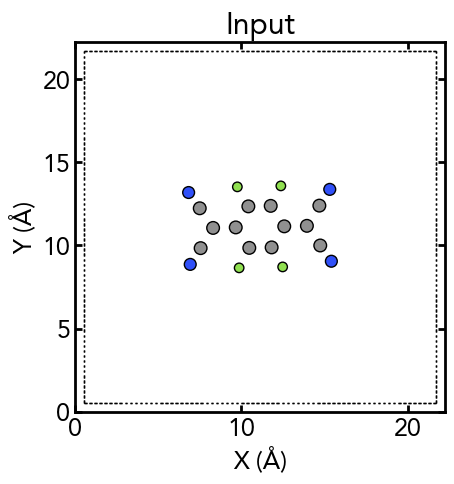

In [ ]:
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.visualize.plot import animate

# Read the atomic structure from the Quantum_ESPRESSO input file
atoms = read(qe_relax_input_file)

# Center the view on the molecule
atoms.center()

# Plot the atoms
fig, ax = plt.subplots(dpi = 300)
plot_atoms(atoms, ax=ax, radii = 0.5, rotation=('0x,0y,0z'))

# Add axis labels
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_title('Input')
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

# Show the plot
plt.show()

If we're happy, we can run the computation to relax the structure.

In [ ]:
! /content/q-e/bin/pw.x  -in F4TCNQ.relax.in > F4TCNQ.relax.out

[687b20ff679d:20681] [[25554,0],0] ORTE_ERROR_LOG: Data unpack had inadequate space in file util/show_help.c at line 513


Now visualize the relaxed structure

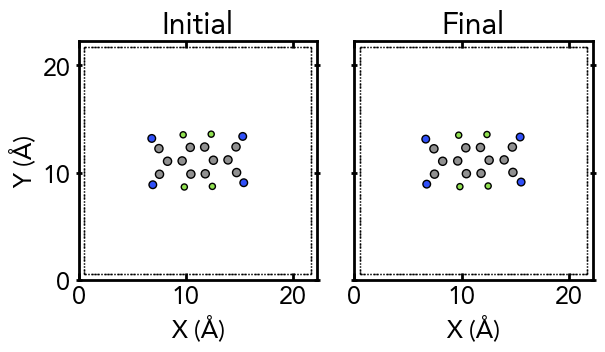


Input atomic positions (Angstrom):
F    11.8375459559   13.0485482597   10.5835400000
F     9.2210473915   12.9905253320   10.5835400000
F     9.3296717811    8.1189701881   10.5835400000
F    11.9460691435    8.1762773100   10.5835400000
N     6.2918029468   12.6499123272   10.5835400000
N     6.3883592538    8.3280319218   10.5835400000
N    14.8751234050    8.5171027406   10.5835400000
N    14.7787545396   12.8388905962   10.5835400000
C     6.9603210858   11.7018043587   10.5835400000
C     7.0138672126    9.3050512115   10.5835400000
C    14.2066118200    9.4652156081   10.5835400000
C    14.1531493475   11.8619337965   10.5835400000
C     7.7632400080   10.5207665904   10.5835400000
C    13.4036924793   10.6462640547   10.5835400000
C    12.0421176605   10.6158602775   10.5835400000
C    11.2833322211    9.3497195044   10.5835400000
C     9.9399047795    9.3206477086   10.5835400000
C     9.1247812328   10.5512083461   10.5835400000
C    11.2273820168   11.8468816306   10.583540

In [ ]:
from ase import Atoms
from ase.io import read
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.visualize.plot import animate
import matplotlib.pyplot as plt
import numpy as np

# Read the atomic structure from the QE input and output files
atoms_initial = read(qe_relax_input_file)
atoms_final = read(qe_relax_output_file)

# # Center the view on the molecules
# atoms_initial.center()
# atoms_final.center()

# Create subplots
fig, axs = plt.subplots(1,2, dpi = 300)

# Plot the original atoms
plot_atoms(atoms_initial, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'))
axs[0].set_title('Initial')

# Add axis labels
axs[0].set_xlabel('X (Å)')
axs[0].set_ylabel('Y (Å)')
axs[0].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[0].yaxis.set_tick_params(which='both', size=5, width=2, direction='inout', right='on')

# Plot the modified atoms
plot_atoms(atoms_final, ax=axs[1], radii=0.5, rotation=('0x,0y,0z'))
axs[1].set_title('Final')
axs[1].set_yticklabels([])

# Add axis labels
axs[1].set_xlabel('X (Å)')
# axs[1].set_ylabel('Y (Å)')
axs[1].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[1].yaxis.set_tick_params(which='both', size=5, width=2, direction='inout', right='on')

plt.tight_layout()

# Show the plot
plt.show()

# Print the original atomic positions
print("\nInput atomic positions (Angstrom):")
for atom in atoms_initial:
    print(f"{atom.symbol:2} {atom.position[0]:15.10f} {atom.position[1]:15.10f} {atom.position[2]:15.10f}")

# Print the modified atomic positions
print("\nFinal atomic positions (Angstrom):")
for atom in atoms_final:
    print(f"{atom.symbol:2} {atom.position[0]:15.10f} {atom.position[1]:15.10f} {atom.position[2]:15.10f}")

# Calculate and print the difference in the initial and final position of all atoms
print("\nDifference in the initial and final position of all atoms (Angstrom):")
for atom_initial, atom_final in zip(atoms_initial, atoms_final):
    diff = atom_final.position - atom_initial.position
    print(f"{atom_initial.symbol:2} {diff[0]:15.10f} {diff[1]:15.10f} {diff[2]:15.10f}")

# Save the figure
fig.savefig('/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/F4TCNQ_relaxation.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

# 2. Self-consistent field calculation

To improve accuracy, we need core-hole pseudopotentials. To do this, we will take an existing, established pseudopotential, parse the input used to generate it, and modify it to have a core hole. Specifically, remove an electron from the 1s core level, turning it from a 1s^2 configuration to a 1s^1 configuration. An example is shown at this link: https://indico.ictp.it/event/a11191/session/17/contribution/9/material/0/0.pdf. If we use the `C.pbe-n-kjpaw_psl.1.0.0.UPF` pseudopotential file from the SSSP efficiency library as a basis, the input used to generate it was:

```
 &input
   title='C',
   zed=6.,
   rel=1,
   config='[He] 2s2 2p2',
   iswitch=3,
   dft='PBE'
 /
 &inputp
   lpaw=.true.,
   pseudotype=3,
   file_pseudopw='C.pbe-n-kjpaw_psl.1.0.0.UPF',
   author='ADC',
   lloc=-1,
   rcloc=0.9
   which_augfun='PSQ',
   rmatch_augfun_nc=.true.,
   nlcc=.true.,
   new_core_ps=.true.,
   rcore=0.7,
   tm=.true.
 /
4
2S  1  0  2.00  0.00  1.00  1.20  0.0
2S  1  0  0.00  3.00  1.00  1.20  0.0
2P  2  1  2.00  0.00  0.90  1.40  0.0
2P  2  1  0.00  0.05  0.90  1.40  0.0
```

The corresponding core hole pseudopotential file can be generated using the following modified input:



```
qe_ld1_input_file = 'C_corehole.in'
qe_ld1_output_file = 'C_corehole.out'
```



```
qe_input = """
 &input
   title='C_corehole',
   zed=6.,
   rel=1,
   config='1s1 2s2 2p2',
   iswitch=3,
   dft='PBE'
 /
 &inputp
   lpaw=.true.,
   pseudotype=3,
   file_pseudopw='C_corehole.pbe-n-kjpaw_psl.1.0.0.UPF',
   author='anonymous',
   lloc=-1,
   rcloc=0.9,
   which_augfun='PSQ',
   rmatch_augfun_nc=.true.,
   nlcc=.true.,
   new_core_ps=.true.,
   rcore=0.7,
   tm=.true.,
   lgipaw_reconstruction=.true.,
 /
4
2S  1  0  2.00  0.00  1.00  1.20  0.0
2S  1  0  0.00  3.00  1.00  1.20  0.0
2P  2  1  2.00  0.00  0.90  1.40  0.0
2P  2  1  0.00  0.05  0.90  1.40  0.0
"""

# We write the input script
with open(qe_ld1_input_file, "w") as f:
    f.write(qe_input)
```

The core hole pseudopotential file can now be generated using `ld1.x`.

```
! /content/q-e/bin/ld1.x  -in C_corehole.in > C_corehole.out
```

In [ ]:
qe_ld1_input_file = 'F_corehole.in'
qe_ld1_output_file = 'F_corehole.out'

In [ ]:
qe_input = """
 &input
   title='F',
   zed=9.,
   rel=1,
   config='1s1 2s2 2p5',
   iswitch=3,
   dft='PBE'
 /
 &inputp
   lpaw = .true.,
   use_xsd=.FALSE.,
   pseudotype=3,
   file_pseudopw='F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF',
   author='ADC',
   lloc=-1,
   rcloc=0.9
   which_augfun='PSQ',
   rmatch_augfun_nc=.true.,
   nlcc=.true.,
   new_core_ps=.true.,
   rcore=0.7,
   tm=.true.
   lgipaw_reconstruction=.true.,
 /
4
2S  1  0  2.00  0.00  1.00  1.30  0.0
2S  1  0  0.00  0.40  1.00  1.30  0.0
2P  2  1  5.00  0.00  0.90  1.40  0.0
2P  2  1  0.00  0.15  0.90  1.40  0.0
"""

# We write the input script
with open(qe_ld1_input_file, "w") as f:
    f.write(qe_input)

Let's generate the core hole pseudopotential file.

In [ ]:
! /content/q-e/bin/ld1.x  -in F_corehole.in > F_corehole.out

Write the input file for SCF calculations:

In [12]:
qe_input = """
&CONTROL
    calculation='scf',
    prefix='F4TCNQ',
    outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/',
    pseudo_dir = '/content/drive/MyDrive/Quantum_ESPRESSO/Pseudopotentials/',
/
&SYSTEM
    ibrav = 1,
    celldm(1) = 40,
    nat = 20,
    ntyp = 4,
    ecutwfc=40,
    occupations='smearing',
    smearing='fd',
    degauss=0.0019,
/
&ELECTRONS
    mixing_beta=0.3,
/

ATOMIC_SPECIES
F_h 12.011 F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF
F 18.988 F.pbe-n-kjpaw_psl.1.0.0.UPF
N 14.007 N.pbe-n-radius_5.UPF
C 12.011 C.pbe-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS angstrom
F_h    11.8469406470   13.0162708068   10.5835400000
F     9.2092815832   12.9541230683   10.5835400000
F     9.3201752993    8.1508413522   10.5835400000
F    11.9578262780    8.2129247723   10.5835400000
N     6.1348503250   12.5869434998   10.5835400000
N     6.2257504238    8.3849262516   10.5835400000
N    15.0320276118    8.5799897308   10.5835400000
N    14.9413123501   12.7822066690   10.5835400000
C     6.8983666301   11.6852269965   10.5835400000
C     6.9500703358    9.3184057341   10.5835400000
C    14.2686675333    9.4818335594   10.5835400000
C    14.2170305124   11.8486952333   10.5835400000
C     7.7151403197   10.5189753228   10.5835400000
C    13.4519700600   10.6481266860   10.5835400000
C    12.0503086797   10.6177621788   10.5835400000
C    11.2949428385    9.3923402868   10.5835400000
C     9.9264224874    9.3603195407   10.5835400000
C     9.1167841671   10.5493297731   10.5835400000
C    11.2406924602   11.8067303048   10.5835400000
C     9.8721579929   11.7747714803   10.5835400000

K_POINTS automatic
1 1 1 0 0 0
"""

# We write the input script
with open(qe_scf_input_file, "w") as f:
    f.write(qe_input)

Let's check the input file to make sure we're using the relaxed atomic coordinates.

In [18]:
from ase import Atoms
from ase.io import read
import numpy as np

# Read the final atomic structure from the QE output file
atoms_relax = read(qe_relax_output_file)

# Read the initial atomic structure from the QE SCF input file
atoms_scf = read(qe_scf_input_file)

# Check if the atomic positions in the SCF input are the same as the final positions from the relaxation
if np.allclose(atoms_relax.positions, atoms_scf.positions):
    print("The atomic positions in the SCF input file are the same as the final positions from the relaxation.")
else:
    print("The atomic positions in the SCF input file are different from the final positions from the relaxation.")
    print("The SCF input file needs to be modified to use the final atomic positions from the relaxation.")
    print("\nFinal atomic positions from the relaxation (Angstrom):")
    for atom in atoms_relax:
        print(f"{atom.symbol:2} {atom.position[0]:15.10f} {atom.position[1]:15.10f} {atom.position[2]:15.10f}")

The atomic positions in the SCF input file are the same as the final positions from the relaxation.


If we're happy, we can run the SCF calculation.

In [13]:
! /content/q-e/bin/pw.x  -in F4TCNQ.scf.in > F4TCNQ.scf.out

# 3. XSpectra calculation

The XSpectra calculation additionally needs the core wavefunction from the pseudopotential file. We can do this using a tool provided with XSpectra.

In [14]:
! /content/q-e/XSpectra/tools/upf2plotcore.sh /content/drive/MyDrive/Quantum_ESPRESSO/Pseudopotentials/F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF > current_wfc.wfc

Write the input file for XSpectra calculations:

In [15]:
qe_input = """
&input_xspectra
    calculation='xanes_dipole'
    prefix='F4TCNQ',
    outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/',
    xniter=1000,
    xcheck_conv=50,
    xkvec(1)=1,
    xkvec(2)=0,
    xkvec(3)=0,
    xepsilon(1)=0,
    xepsilon(2)=0,
    xepsilon(3)=1,
    xiabs=1,
    x_save_file='F4TCNQ.xspectra.sav',
    xerror=0.001,
 /
&plot
    xnepoint=300,
    xemin=-10.0,
    xemax=30.0,
    terminator=.true.,
    cut_occ_states=.true.,
    xanes_file='F4TCNQ_F_xkvec100_xepsilon001_xanes.dat',
    xgamma=0.8
/
&pseudos
    filecore='current_wfc.wfc',
/
&cut_occ
/
1 1 1 0 0 0
"""

# We write the input script
with open(qe_xspectra_input_file, "w") as f:
    f.write(qe_input)

In [ ]:
! /content/q-e/bin/xspectra.x  -in F4TCNQ.xspectra.in > F4TCNQ.xspectra.out

Let's run XSpectra programmatically for all polarizations along the x-, y-, and z-axis.

In [16]:
! /content/q-e/XSpectra/tools/upf2plotcore.sh /content/drive/MyDrive/Quantum_ESPRESSO/Pseudopotentials/F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF > current_wfc.wfc

In [17]:
# Define the possible values for xkvec and xepsilon
values = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

# Initialize the lists
xkvec_values = []
xepsilon_values = []
xanes_files = []

# Generate the values and file names
for xepsilon in values:
    for xkvec in values:
        if xkvec != xepsilon:  # The xkvec and xepsilon vectors should be orthogonal
            xepsilon_values.append(xepsilon)
            xkvec_values.append(xkvec)
            # Generate the file name based on the xkvec and xepsilon values
            xanes_file = f'F4TCNQ_F_xkvec{"%i%i%i" % xkvec}_xepsilon{"%i%i%i" % xepsilon}_xanes.dat'
            xanes_files.append(xanes_file)

for xkvec, xepsilon, xanes_file in zip(xkvec_values, xepsilon_values, xanes_files):
    qe_input = f"""
    &input_xspectra
        calculation='xanes_dipole'
        prefix='F4TCNQ',
        outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/',
        xniter=1000,
        xcheck_conv=50,
        xkvec(1)={xkvec[0]},
        xkvec(2)={xkvec[1]},
        xkvec(3)={xkvec[2]},
        xepsilon(1)={xepsilon[0]},
        xepsilon(2)={xepsilon[1]},
        xepsilon(3)={xepsilon[2]},
        xiabs=1,
        x_save_file='F4TCNQ.xspectra.sav',
        xerror=0.001
     /
    &plot
        xnepoint=300,
        xemin=-10.0,
        xemax=30.0,
        terminator=.true.,
        cut_occ_states=.true.,
        xanes_file='{xanes_file}',
        xgamma=0.8
    /
    &pseudos
        filecore='current_wfc.wfc',
    /
    &cut_occ
    /
    1 1 1 0 0 0
    """

    # We write the input script
    with open(qe_xspectra_input_file, "w") as f:
        f.write(qe_input)

    # Run XSpectra
    ! /content/q-e/bin/xspectra.x  -in F4TCNQ.xspectra.in > F4TCNQ.xspectra.out

Let's visualize the results. The following cell searches for all files with a given prefix and suffix and plots them.

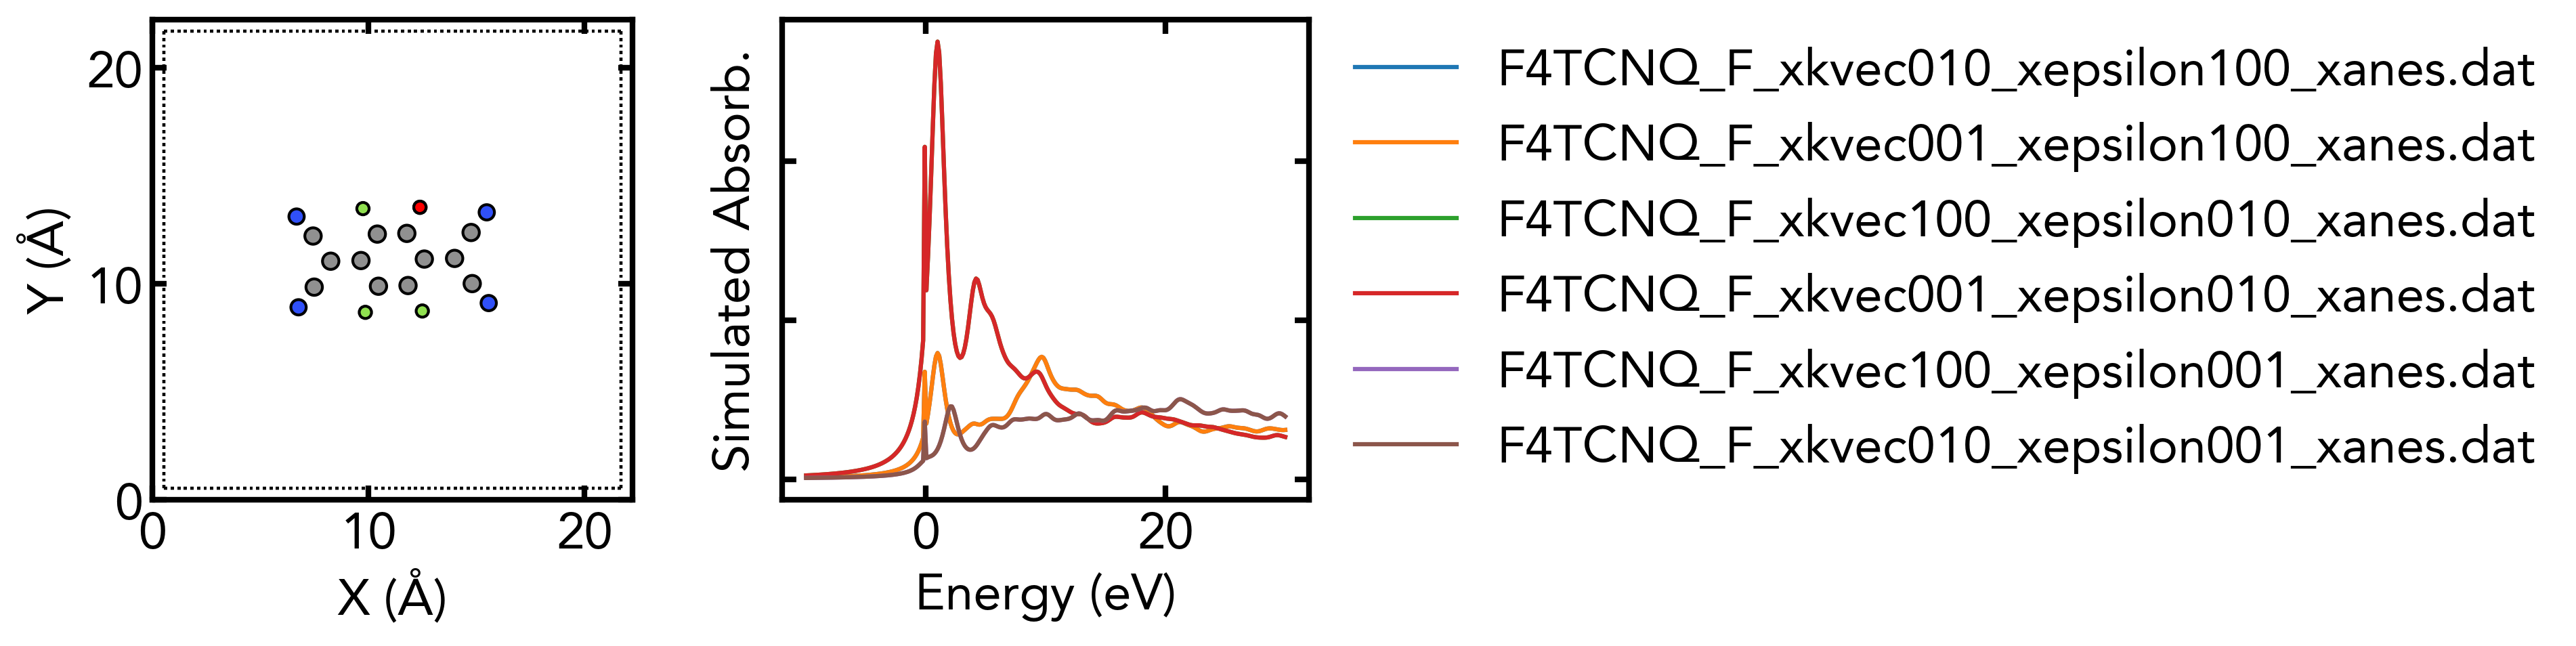

In [18]:
from ase import Atoms
from ase.io import read
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.visualize.plot import animate
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import glob

# Get a list of all '_xanes.dat' files
xanes_files = glob.glob('F4TCNQ_F_*_xanes.dat')

# Read atomic positions
atoms = read(qe_scf_input_file)

# Create subplots
fig, axs = plt.subplots(1,2, figsize = (7, 3.5), dpi=300)

# Parse the SCF input file to find the position of the core hole atom
with open(qe_scf_input_file, 'r') as file:
    lines = file.readlines()

start_line = lines.index("ATOMIC_POSITIONS angstrom\n") + 1
end_line = lines.index("\n", start_line)
atomic_positions_lines = lines[start_line:end_line]

atomic_positions = []
for line in atomic_positions_lines:
    elements = line.split()
    atom_type, x, y, z = elements[0], float(elements[1]), float(elements[2]), float(elements[3])
    atomic_positions.append((atom_type, x, y, z))

corehole_position = next((x, y, z) for atom_type, x, y, z in atomic_positions if atom_type == "F_h")

# Find the atom type in the atoms object that corresponds to the core hole position
corehole_atom_type = next(atom.symbol for atom in atoms if np.allclose(atom.position, corehole_position))

# Create an Atoms object for the core hole atom
atoms_corehole = Atoms(corehole_atom_type, positions=[corehole_position])
atoms_corehole.set_cell(atoms.get_cell())

# Plot the atoms
plot_atoms(atoms, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'))

# Plot the core hole atom with a different color
plot_atoms(atoms_corehole, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'), colors=['r'])

# Add axis labels
axs[0].set_xlabel('X (Å)')
axs[0].set_ylabel('Y (Å)')
axs[0].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[0].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

# Iterate over all '_xanes.dat' files
for file_name in xanes_files:
    # Initialize empty lists for energy and sigma
    energy = []
    sigma = []

    # Read file
    with open(file_name, 'r') as file:
        for line in file:
            # Skip lines that start with '#'
            if line[0] != '#':
                # Split the line into energy and sigma
                e, s = line.split()
                # Append to lists
                energy.append(float(e))
                sigma.append(float(s))

    # Plot the spectra
    axs[1].plot(energy, sigma, label=file_name)

# Add axis labels
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel(r'Simulated Absorb.')
axs[1].set_yticklabels([])
axs[1].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[1].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

plt.tight_layout()

# Add legend to the right of the second plot
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Show the plot
plt.show()

# Save the figure
fig.savefig('/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/F4TCNQ_F_Kedge.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

In NEXAFS spectroscopy, the orientation of the molecule relative to the polarization of the incident X-ray can influence the observed spectra. To explore this dependence, one can fix the direction of polarization and rotate the molecule accordingly. This leads to the NEXAFS signal being a vector component-weighted sum of contributions from the x-, y-, and z-polarized NEXAFS.

In the example code below, we simulate this situation by setting a fixed polarization direction along the x-axis (hence it is labeled "polarization axis", though it represents a real spatial direction) and rotating the molecule to match. The y-axis is labeled "X-ray wave vector axis", as it is orthogonal to the polarization direction. Note that in this approximation, we assume the direction of the wave vector propagation (i.e., the direction the X-ray is coming from) does not influence the NEXAFS, which is a reasonable assumption for many systems.

This approach provides a way to understand how the NEXAFS changes with molecular orientation, which can be crucial for interpreting experimental data.

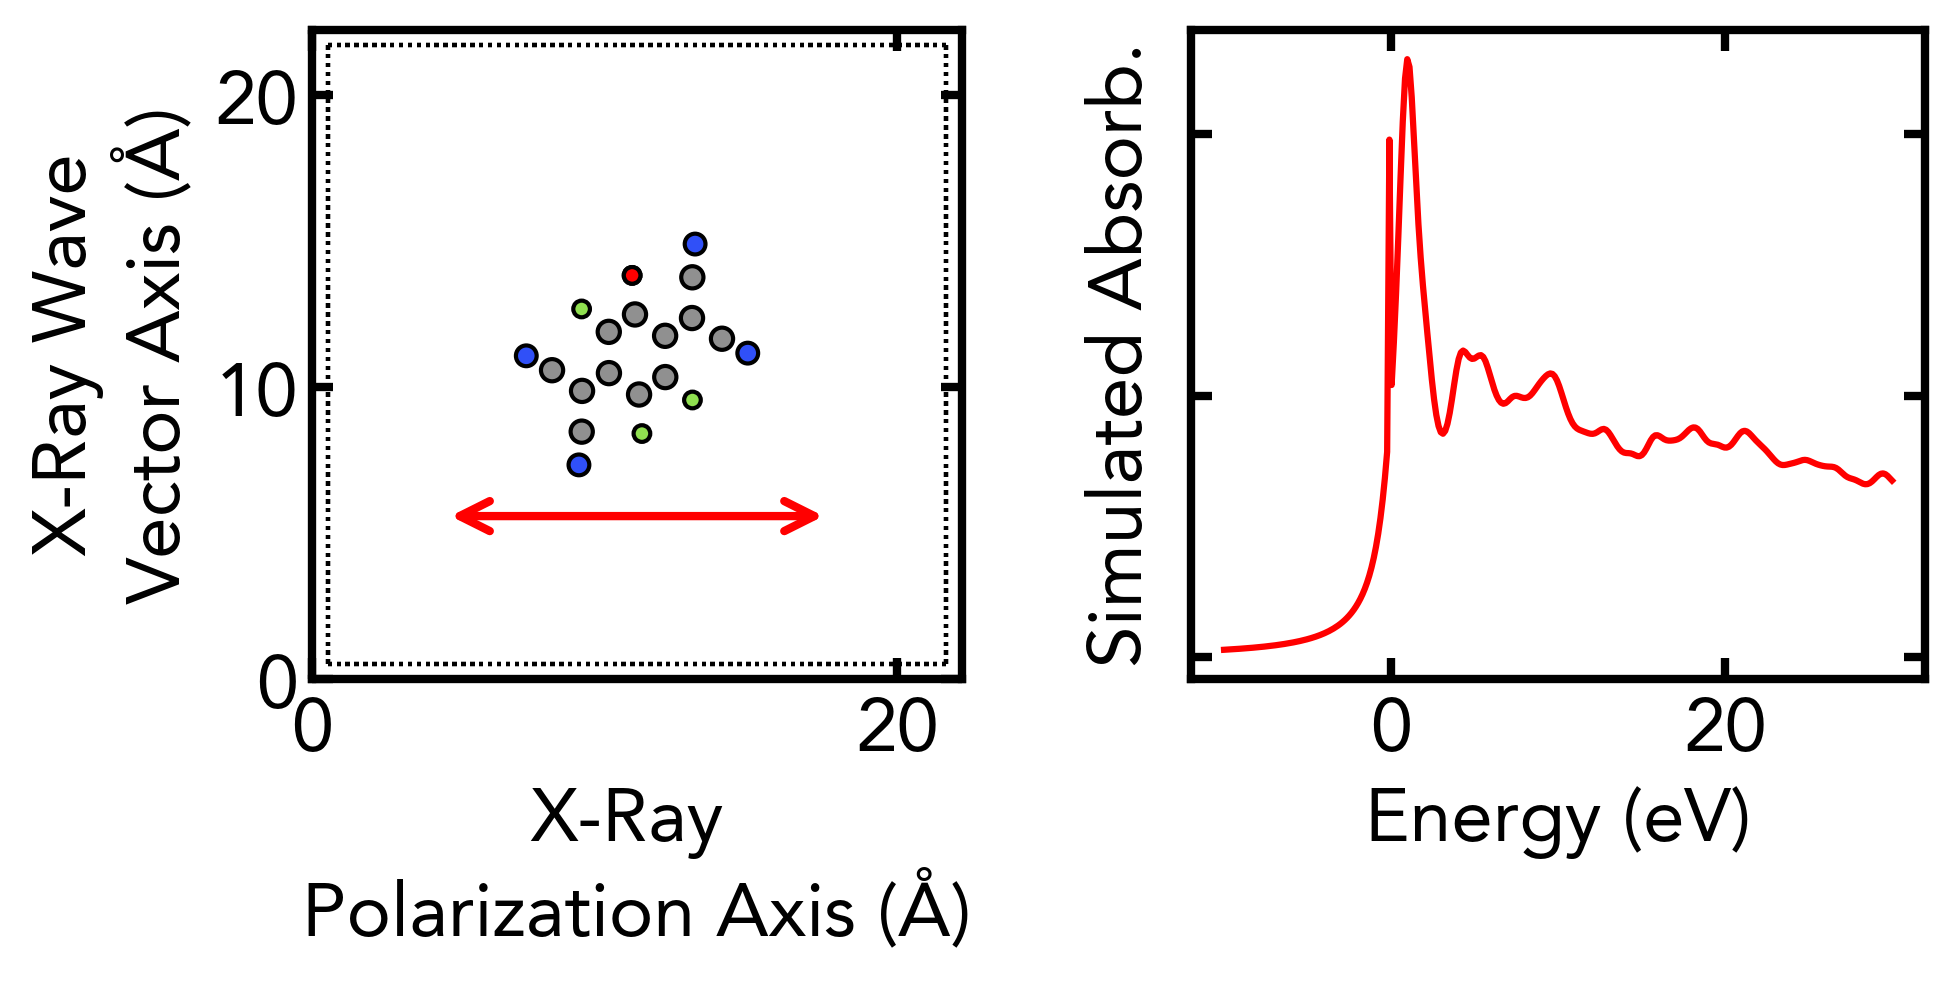

In [19]:
from scipy.spatial.transform import Rotation as R
import glob
import matplotlib.pyplot as plt
import ase.visualize.plot as ase_plot
from ase.visualize.plot import plot_atoms
from ase import Atoms
import numpy as np
from ase.io import read

# Function to rotate atomic positions
def rotate_positions(atoms, rotation, center):
    rotated_atomic_positions = []
    for atom in atoms:
        position = atom.position - center
        rotated_position = rotation.apply([position])[0]
        rotated_atomic_positions.append((atom.symbol, *(rotated_position + center)))
    return rotated_atomic_positions

# Specify the user-defined weights for the x-, y-, and z-polarized contributions
weights = [1, 2, 3]  # example weights

# Check if the weights sum to 1
if not np.isclose(sum(weights), 1):
    # If they don't, normalize the weights and print a warning
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    print("Warning: The weights did not sum to 1 and have been normalized.")

# Check if the weights are isotropic
isotropic = np.allclose(weights, [1/3, 1/3, 1/3])

if isotropic:
    print("The weights are isotropic. The molecule is randomly oriented and no rotation is applied.")

# Get a list of all '_xanes.dat' files
xanes_files_100 = glob.glob('F4TCNQ_F_*100_xanes.dat')
xanes_files_010 = glob.glob('F4TCNQ_F_*010_xanes.dat')
xanes_files_001 = glob.glob('F4TCNQ_F_*001_xanes.dat')

# Lists of files
xanes_files_lists = [xanes_files_100, xanes_files_010, xanes_files_001]

# Initialize lists to store the energy and sigma values for each file
energy_values = []
sigma_values = []

# Iterate over the lists of files
for xanes_files in xanes_files_lists:
    # Initialize lists to store the energy and sigma values for the current list of files
    energy_list = []
    sigma_list = []

    # Iterate over the files in the current list
    for xanes_file in xanes_files:
        # Initialize empty lists for energy and sigma
        energy = []
        sigma = []

        # Read file
        with open(xanes_file, 'r') as file:
            for line in file:
                # Skip lines that start with '#'
                if line[0] != '#':
                    # Split the line into energy and sigma
                    e, s = line.split()
                    # Append to lists
                    energy.append(float(e))
                    sigma.append(float(s))

        # Add the energy and sigma values to their respective lists
        energy_list.append(energy)
        sigma_list.append(sigma)

    # Add the average energy and sigma values to their respective lists
    energy_values.append(np.mean(energy_list, axis=0))
    sigma_values.append(np.mean(sigma_list, axis=0))

# Calculate the weighted sum of the sigma values
weighted_sigma_sum = sum(w * s for w, s in zip(weights, sigma_values))

# Read atomic positions
atoms = read(qe_scf_input_file)

# Calculate the center of the molecule
center = atoms.get_center_of_mass()

# Calculate the net polarization direction
net_polarization = np.array(weights)

# Calculate the angle and rotation axis
angle = np.arccos(np.dot(net_polarization, [1, 0, 0]))
axis = np.cross([1, 0, 0], net_polarization)
rotation_vector = axis * angle

# If the net polarization
# Continue the code
rotation = None
if not np.allclose(net_polarization, [1, 0, 0]) and not isotropic:
    rotation = R.from_rotvec(rotation_vector)

# Read the atomic positions and apply rotation if necessary
rotated_atomic_positions = rotate_positions(atoms, rotation, center) if rotation else [(atom.symbol, *atom.position) for atom in atoms]

# Create an Atoms object for the rotated atoms
atoms_rotated = Atoms([atom_symbol for atom_symbol, _, _, _ in rotated_atomic_positions],
                      positions=[pos for _, *pos in rotated_atomic_positions])
atoms_rotated.set_cell(atoms.get_cell())

# Parse the SCF input file to find the position of the core hole atom
with open(qe_scf_input_file, 'r') as file:
    lines = file.readlines()

start_line = lines.index("ATOMIC_POSITIONS angstrom\n") + 1
end_line = lines.index("\n", start_line)
atomic_positions_lines = lines[start_line:end_line]

atomic_positions = []
for line in atomic_positions_lines:
    elements = line.split()
    atom_type, x, y, z = elements[0], float(elements[1]), float(elements[2]), float(elements[3])
    atomic_positions.append((atom_type, x, y, z))

corehole_position = next((x, y, z) for atom_type, x, y, z in atomic_positions if atom_type == "F_h")

# Find the atom type in the atoms object that corresponds to the core hole position
corehole_atom_type = next(atom.symbol for atom in atoms if np.allclose(atom.position, corehole_position))

# Create an Atoms object for the core hole atom
atoms_corehole = Atoms(corehole_atom_type, positions=[corehole_position])
atoms_corehole.set_cell(atoms.get_cell())

# Apply rotation to the core hole atom if necessary
rotated_corehole_positions = rotate_positions(atoms_corehole, rotation, center) if rotation else [(atom.symbol, *atom.position) for atom in atoms_corehole]

# Create an Atoms object for the rotated core hole atom
atoms_corehole_rotated = Atoms([atom_symbol for atom_symbol, _, _, _ in rotated_corehole_positions],
                               positions=[pos for _, *pos in rotated_corehole_positions])
atoms_corehole_rotated.set_cell(atoms_corehole.get_cell())

# Create subplots
fig, axs = plt.subplots(1,2, figsize = (7, 3.5), dpi=300)

# Plot the rotated atoms
ase_plot.plot_atoms(atoms_rotated, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'))

# Plot the rotated core hole atom with a different color
plot_atoms(atoms_corehole_rotated, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'), colors=['r'])

# Plot the resulting weighted sum
axs[1].plot(energy_values[0], weighted_sigma_sum, label='Weighted Sum \n(Randomly Oriented)' if isotropic else 'Weighted Sum', color='red', linewidth=1.5)

# Add axis labels
axs[0].set_xlabel('X-Ray \nPolarization Axis (Å)')
axs[0].set_ylabel('X-Ray Wave\nVector Axis (Å)')
axs[0].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[0].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel(r'Simulated Absorb.')
axs[1].set_yticklabels([])
axs[1].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[1].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

# First, find the extent of the x-axis to place the arrow appropriately.
x_min, x_max = axs[0].get_xlim()

# Calculate the y position for the arrow. This places the arrow 2 Angstroms below the center of mass of the molecule.
arrow_y_position = atoms.get_center_of_mass()[1] - 5

# Calculate the start and end x positions for the arrow. This places the arrow 10% away from the edges of the plot.
arrow_x_start = x_min + 0.2 * (x_max - x_min)
arrow_x_end = x_max - 0.2 * (x_max - x_min)

if isotropic:
    # If the weights are isotropic, print the text instead of the arrow.
    axs[0].text(x_min + 0.5 * (x_max - x_min), arrow_y_position, "Isotropic Polarization", horizontalalignment='center', verticalalignment='center', fontsize=10, color='red')
else:
    # Draw a double-headed arrow to represent the polarization direction.
    axs[0].annotate("", xy=(arrow_x_end, arrow_y_position), xytext=(arrow_x_start, arrow_y_position),
                    arrowprops=dict(arrowstyle="<->", lw=2, color='red'))

plt.tight_layout()

# Add legend to the right of the second plot
# axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()

fig.savefig('/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/F4TCNQ_F_Kedge_weighted_sum.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)